# TrueLayer
## Technical Challenge: Machine Learning Engineer Task - Movie Classifier
### Solution done by: Ibrahim Ben Abdallah
### E-mail: ibrahim.b.abdallah@gmail.com
- This notebook contains the workflow of the training process for the movie classifier.
- This training pipeline is done following the CRISP-DM methodology
- Training data: [The Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset/version/7#movies_metadata.csv) (movies_metadata.csv)

<img src="crisp-dm.png">

### Requirements:
- python 3.6.9
- nltk==3.4.5
- pandas==1.1.4
- matplotlib==2.2.3
- scikit-learn==0.24.1
- xgboost==0.90

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import  XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import pickle
import re

In [109]:
stopwords_list = set(stopwords.words('english'))

### Import Data 

In [110]:
df = pd.read_csv("movies_metadata.csv")

C:\Users\USER\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Extract Genre of each movie in the Dataset 

In [111]:
df

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


### According to the MovieLens Dataset from kaggle, each movie has one or more genres, in our case we're going to select only one genre for each movie to perform a multiclass classification problem.

In [112]:
def extract_genre(genres):
    """
    Description: 
        extract the first genre from the list of genres the movie is classified as
    input: 
        list of dicts
    output: 
        genre: str
    """
    genres = eval(genres)
    if len(genres) > 0:
        return genres[0]['name']
    else:
        return None

In [113]:
df.genres = df.genres.apply(lambda x: extract_genre(x))

In [114]:
df.genres

0        Animation
1        Adventure
2          Romance
3           Comedy
4           Comedy
           ...    
45461        Drama
45462        Drama
45463       Action
45464         None
45465         None
Name: genres, Length: 45466, dtype: object

### The number of unique Genres 

In [115]:
df.genres.nunique()

23

### The list of available genres 

In [116]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

### Feature Selection
- Since the inputs of our movie classifier application are the movie title and the movie description, we're going to select only these variables in addition of the genre which is our target to train a classifier.

In [117]:
df = df[["original_title", "overview", "genres"]]

In [118]:
df

,original_title,overview,genres
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",Animation
1,Jumanji,When siblings Judy and Peter discover an encha...,Adventure
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,Romance
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",Comedy
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,Comedy
...,...,...,...
45461,رگ خواب,Rising and falling between a man and woman.,Drama
45462,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,Drama
45463,Betrayal,"When one of her hits goes wrong, a professiona...",Action
45464,Satana likuyushchiy,"In a small town live two brothers, one a minis...",None


### Compute null percentage in our data 

In [119]:
(df.isna().sum() / len(df)) * 100

original_title    0.000000
overview          2.098271
genres            5.371046
dtype: float64

### Drop rows with null overviews or genres since they're very few and they wont affect our training data 

In [120]:
df = df.dropna()

In [121]:
(df.isna().sum() / len(df)) * 100

original_title    0.0
overview          0.0
genres            0.0
dtype: float64

In [122]:
df

,original_title,overview,genres
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",Animation
1,Jumanji,When siblings Judy and Peter discover an encha...,Adventure
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,Romance
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",Comedy
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,Comedy
...,...,...,...
45459,Caged Heat 3000,It's the year 3000 AD. The world's most danger...,Science Fiction
45460,Robin Hood,"Yet another version of the classic epic, with ...",Drama
45461,رگ خواب,Rising and falling between a man and woman.,Drama
45462,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,Drama


### Visualize the number of movies per genre 

<BarContainer object of 23 artists>

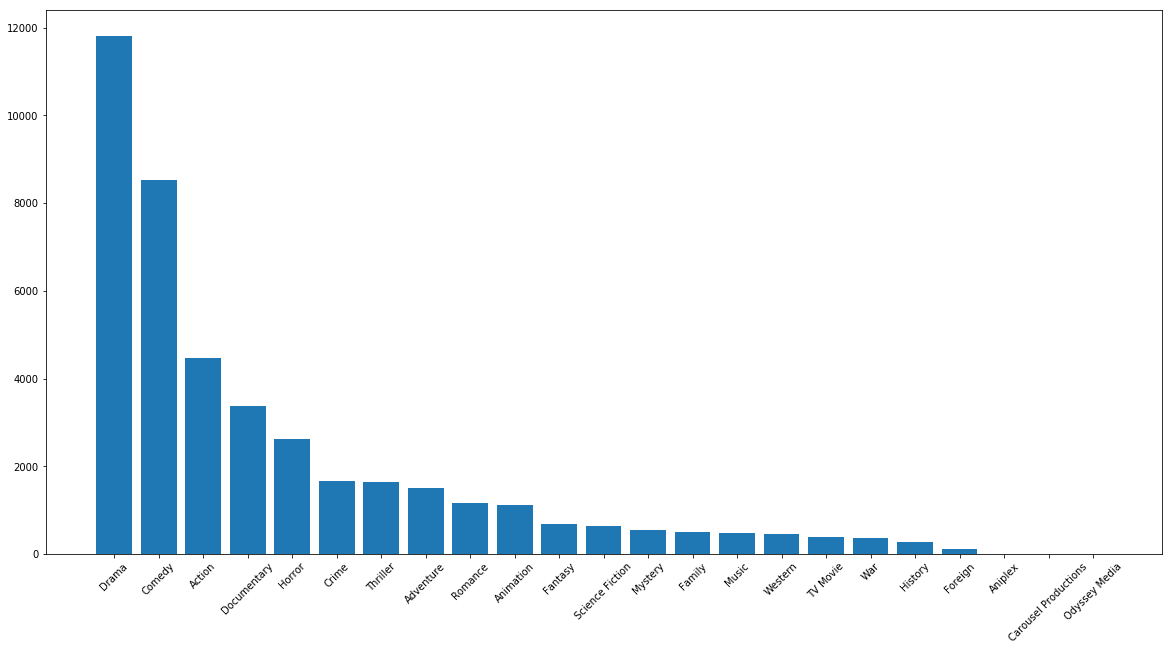

In [123]:
f, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation=45)
plt.bar(df.genres.value_counts().index, df.genres.value_counts())

# Data Cleaning

### Delete movies with genres "Odyssey Media", "Aniplex" and "Carousel Productions" since they have a very small cardinality (only one instance is present for each of these 3 genres).
- These 3 movie genres won't be relevent during the training process

In [124]:
df = df[~df.genres.isin(['Carousel Productions', 'Aniplex', 'Odyssey Media'])]

### The list of the final genres 

In [125]:
df.genres.unique()

array(['Animation', 'Adventure', 'Romance', 'Comedy', 'Action', 'Family',
       'History', 'Drama', 'Crime', 'Fantasy', 'Science Fiction',
       'Thriller', 'Music', 'Horror', 'Documentary', 'Mystery', 'Western',
       'TV Movie', 'War', 'Foreign'], dtype=object)

### Clean Text  

In [126]:
def clean_overview(text):
    """
    Description: 
        this function cleans an input text and return a 'clean' version ready to be vectorized.
        This function removes extra spaces, remove apostrophies and all the special characters and lower all the remaining characters from a given string.
    Input:
        Text: str
    Output:
        A clean version of the input text: str
    """
    text = re.sub("\s+", " ", text) # remove extra spaces
    text = re.sub("\'", "", text) # remove apostrophies
    text = re.sub("[^A-Za-z ]", "", text) # select only letters / remove special characters
    text = text.lower() # lower all the remaining characters
    return text

### Apply the text cleaning to the movies overview 

In [ ]:
df["overview_clean"] = df["overview"].apply(lambda x: clean_overview(x))

### Remove Stopwords

In [128]:
def remove_stopwords(text):
    """
    Description: 
        Remove stopwords from a given text
    Input:
        Text: str
    Output:
        str
    """
    clean_text = [x for x in text.split() if not x in stopwords_list]
    return " ".join(clean_text)

### Remove stopwords from the movies overview 

In [129]:
df["overview_clean"] = df["overview_clean"].apply(lambda x: remove_stopwords(x))

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Lemmatization

In [130]:
def lemmatization(text):
    """
    Description: 
        Apply Lemmatization to a given text. This function allows to take each word from the given string to its root form called Lemma. It helps to bring words to their dictionary form.
    Input:
        Text: str
    Output:
        str
    """
    lemmatizer = nltk.WordNetLemmatizer()
    clean_text = [lemmatizer.lemmatize(word) for word in text.split()]
    return " ".join(clean_text)

### Apply Lemmatization to the movies overview 

In [131]:
df["overview_clean"] = df["overview_clean"].apply(lambda x: lemmatization(x))

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Visualize the frequences of words presents in our corpus.
- The corpus contains all the unique words presents in all the overviews in our movie Dataset

<BarContainer object of 500 artists>

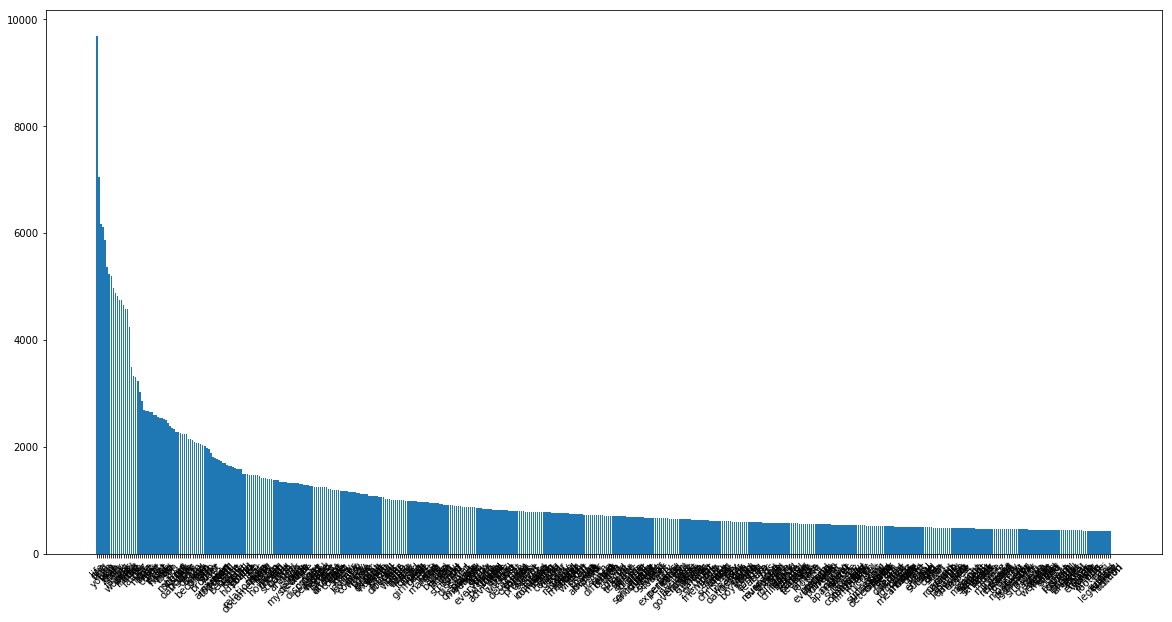

In [132]:
all_words = " ".join([text for text in df.overview_clean])
all_words_list = all_words.split()
word_counts = nltk.FreqDist(all_words_list) 

df_word_counts = pd.DataFrame(
    {
        'word':list(word_counts.keys()), 
        'count':list(word_counts.values())
    }
) 

top_frequent_words = df_word_counts.nlargest(columns=["count"], n=500)

f, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation=45)
plt.bar(top_frequent_words["word"], top_frequent_words["count"])

### Encoding Target variable 
- Label Encoder will assign a number to each of the labels in our target variable

In [133]:
le = preprocessing.LabelEncoder()
df["target"] = le.fit_transform(df.genres.values)
df

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,original_title,overview,genres,overview_clean,target
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",Animation,led woody andys toy live happily room andys bi...,2
1,Jumanji,When siblings Judy and Peter discover an encha...,Adventure,sibling judy peter discover enchanted board ga...,1
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,Romance,family wedding reignites ancient feud nextdoor...,14
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",Comedy,cheated mistreated stepped woman holding breat...,3
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,Comedy,george bank recovered daughter wedding receive...,3
...,...,...,...,...,...
45459,Caged Heat 3000,It's the year 3000 AD. The world's most danger...,Science Fiction,year ad world dangerous woman banished remote ...,15
45460,Robin Hood,"Yet another version of the classic epic, with ...",Drama,yet another version classic epic enough variat...,6
45461,رگ خواب,Rising and falling between a man and woman.,Drama,rising falling man woman,6
45462,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,Drama,artist struggle finish work storyline cult pla...,6


### Save the label encoder to use it later to extract the original class label from the model predictions

In [134]:
label_encoder_file_name = "label_encoder.pkl"

pickle.dump(le, open(label_encoder_file_name, "wb"))

### Train-Test splitting our data 

In [135]:
X_train, X_test, y_train, y_test = train_test_split(df['overview_clean'], df["target"], test_size=0.3, random_state=26)


### Vectorize input feature: text to vector 
- We need to choose the number of words we're going to use to select the shape of the feature vector 
- Let's try a threshold of 50 frequencies
- Get only words that have frequencies greater than or equal to 50

In [136]:
len(df_word_counts[df_word_counts["count"]>50])

3994

In [137]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=4000)

In [138]:
X_train_features = tfidf_vectorizer.fit_transform(X_train)
X_test_features = tfidf_vectorizer.transform(X_test)

### Save the TF-IDF vectorizer to use it later to vectorize the input of our Movie Classifier application 

In [139]:
tfidf_vectorizer_file_name = "tfidf_vectorizer.pkl"

pickle.dump(tfidf_vectorizer, open(tfidf_vectorizer_file_name, "wb"))

### Modeling
#### We're going to train different types of classification models, fine tune them and choose the best one.
- Linear Model: Logistic Regression
- Tree Based Model: Decision Tree
- Ensemble Method: Random Forest
- Boosted Model: XGBoost

### Logistic Regression 

In [140]:
lr = LogisticRegression()
lr.fit(X_train_features, y_train)
y_pred = lr.predict(X_test_features)

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [141]:
f1_score(y_test, y_pred, average='micro')

0.4527484643250906

### Decision Tree 

In [142]:
dt = DecisionTreeClassifier()
dt.fit(X_train_features, y_train)
y_pred_dt = dt.predict(X_test_features)

In [143]:
f1_score(y_test, y_pred_dt, average='micro')

0.2916994802331076

### Random Forest 

In [144]:
rf = RandomForestClassifier(n_estimators=500, max_depth=5000, min_samples_split=2, min_samples_leaf=3)
rf.fit(X_train_features, y_train)
y_pred_rf = rf.predict(X_test_features)

In [145]:
f1_score(y_test, y_pred_rf, average='micro')

0.4125059064419594

In [146]:
classifier_rf_file_name = "rf_movie_classifier.pkl"

pickle.dump(rf, open(classifier_rf_file_name, "wb"))

### XGBoost 

In [147]:
xgb = XGBClassifier(max_depth=5000, n_estimators=100, learning_rate=0.15, objective="multi:softmax")
xgb.fit(X_train_features, y_train)
y_pred_xgb = xgb.predict(X_test_features)

In [148]:
f1_score(y_test, y_pred_xgb, average='micro')

0.4324303039848795

In [149]:
classifier_xgb_file_name = "xgb_movie_classifier.pkl"

pickle.dump(xgb, open(classifier_xgb_file_name, "wb"))

### The training data is very sparse and we've got high cardinality in our target variables - 20 classes
- I think it's very hard to get a high score, so after a few tunings done to the model we've got an F1-score of 0.43 with XGBoost
- We can apply more advanced techniques for text vectorization like word embedding with Deep Learning and we can add more features to make the models more complex after fine tuning and add regularization to make them generalize better.